In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters

import sklearn.cluster
import sklearn.neighbors
import scipy

import hdbscan

In [103]:
a['dt'] = a.time.diff()
a.tail()

,rte_id,time,lat,lon,elevation,dist,speed,slope,labels,dt
20938,37828753,33743,41.815018,-73.561592,155.0,0.002705,7.212596,0.578951,1,1.0
20939,37828753,33744,41.815037,-73.561638,155.2,0.001725,6.994537,0.578951,1,1.0
20940,37828753,33745,41.815048,-73.561668,155.2,0.001620,6.631535,0.578951,1,1.0
20941,37828753,33746,41.815044,-73.561699,155.2,0.001115,6.317518,0.578951,1,1.0
20942,37828753,33747,41.815029,-73.561707,155.2,0.000000,6.011549,0.578951,1,1.0


In [5]:
RTE_IDS = pd.read_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')


In [61]:
clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=5)
plt.figure(figsize=(5, 5))
for i, rte_id in enumerate(RTE_IDS.rte_id):
#     if rte_id == 23586828: continue
    if not i % 200: print(i)
    a = pd.read_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
    if a.dist.max() < 1/20 * a.dist.sum():
        continue
    print('{} - broken: {:.1f} of {:.1f}'.format(rte_id, a.dist.max(), a.dist.sum()))
    clusterer.fit(a[['lat', 'lon']])
    a['labels'] = clusterer.labels_
    biggest_segment = a.labels.value_counts().index[0]
    
    os.rename(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id), 
              config.CLEAN_TRIPS_PATH + 'junk_feather/{}.feather'.format(rte_id))
    
    a = a[a.labels == biggest_segment].reset_index()
    a.to_feather(config.CLEAN_TRIPS_PATH + '{}.feather'.format(rte_id))
#     for lab in a.labels.unique():
#         if lab == -1:
#             plt.plot(a[a.labels==lab].lon, a[a.labels==lab].lat, '.', color=(0.5, 0.5, 0.5), markersize=0.5)
#         else:
#             plt.plot(a[a.labels==lab].lon, a[a.labels==lab].lat, '.', markersize=0.5)
# #     break

0
23586828 - broken: 12.4 of 113.5
5443624 - broken: 7.6 of 26.8
9906993 - broken: 2.4 of 24.2
15752406 - broken: 3.4 of 37.7
1631790 - broken: 1.6 of 24.0
19071958 - broken: 3.7 of 44.5
33539334 - broken: 11.5 of 31.5
18705152 - broken: 5.4 of 41.3
1879002 - broken: 2.3 of 43.2
34303372 - broken: 7.5 of 36.5
200
9957826 - broken: 9.3 of 68.8
52253313 - broken: 66.1 of 100.6
13714581 - broken: 2.9 of 52.7
13927674 - broken: 1.0 of 16.0
18122861 - broken: 2.7 of 47.1
18115046 - broken: 3.9 of 59.5
33237659 - broken: 3.4 of 63.9
24644349 - broken: 5.4 of 22.4
400
55693008 - broken: 3.3 of 41.4
39368264 - broken: 3.0 of 50.1
11106985 - broken: 2.0 of 39.9
55397838 - broken: 4.0 of 12.9
40387475 - broken: 6.1 of 35.6
600
6178895 - broken: 2.4 of 35.5
15813016 - broken: 7.2 of 48.0
37714008 - broken: 11.4 of 27.0
37828753 - broken: 27.8 of 108.0
22690755 - broken: 3.1 of 27.3
3955839 - broken: 5.2 of 52.1
800
39361371 - broken: 0.4 of 5.9
4932207 - broken: 3.7 of 47.1
11784507 - broken: 2.6

<Figure size 360x360 with 0 Axes>

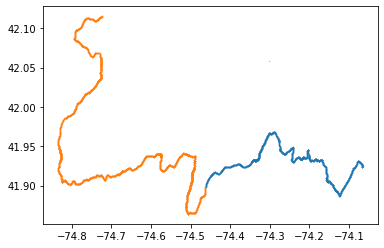

In [74]:
rte_id = 34061155
# 17797178 36965937 9987542 17624737  37828753 52253313 56503690
a = pd.read_feather(config.CLEAN_TRIPS_PATH + 'junk_feather/{}.feather'.format(rte_id))
clusterer.fit(a[['lat', 'lon']])
a['labels'] = clusterer.labels_

for lab in a.labels.unique():
    if lab == -1:
        plt.plot(a[a.labels==lab].lon, a[a.labels==lab].lat, '.', color=(0.5, 0.5, 0.5), markersize=0.5)
    else:
        plt.plot(a[a.labels==lab].lon, a[a.labels==lab].lat, '.', markersize=0.5)

In [78]:
a.labels.value_counts().index.tolist()

[1, 0, -1]

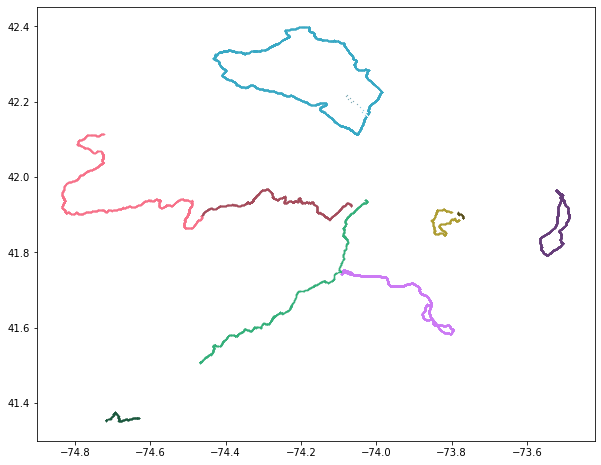

In [99]:
colours = sns.color_palette('husl', 5)
plt.figure(figsize=(10, 10))
#[34061155, 17797178, 36965937, 9987542, 17624737, 37828753, 52253313, 56503690]
for i, rte_id in enumerate([34061155, 17797178, 9987542, 56503690, 37828753]):
    a = pd.read_feather(config.CLEAN_TRIPS_PATH + 'junk_feather/{}.feather'.format(rte_id))
    clusterer.fit(a[['lat', 'lon']])
    a['labels'] = clusterer.labels_
    for ii, lab in enumerate(a.labels.value_counts().index.tolist()):
        if lab == -1: continue
        plt.plot(a[a.labels==lab].lon, a[a.labels==lab].lat, '.', markersize=0.5, color=np.array(colours[i]) * (a.labels.nunique() - ii) / a.labels.nunique())
plt.gca().set_aspect('equal')